In [1]:
import os
#os.environ["PYSPARK_PYTHON"]="/usr/bin/python3.7"
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext
sc = pyspark.SparkContext(master='spark://192.168.11.239:7077', appName='data_cleaner')

In [2]:
!which python

/home/ubuntu/anaconda3/envs/dat500/bin/python


In [3]:
from pyspark.sql.types import *
sqlContext = SQLContext(sc)

In [4]:
from datetime import datetime
from pyspark.sql.functions import *

In [5]:
import sys
print(sys.version_info[:2])

(3, 7)


In [6]:
"""ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location 
Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y 
Coordinate,Year,Updated On,Latitude,Longitude,Location"""


schema = StructType([
StructField("ID", IntegerType()),
StructField("Case Number", StringType()),
StructField("Date", DateType()),
StructField("Block", StringType()),
StructField("IUCR", StringType()),
StructField("Primary Type", StringType()),
StructField("Description", StringType()),
StructField("Location Description", StringType()),
StructField("Arrest", BooleanType()),
StructField("Domestic", BooleanType()),
StructField("Beat", StringType()),
StructField("District", StringType()),
StructField("Ward", IntegerType()),
StructField("Community Area", StringType()),
StructField("FBI Code", StringType()),
StructField("X Coordinate", IntegerType()),
StructField("Y Coordinate", IntegerType()),
StructField("Year", IntegerType()),
StructField("Updated On", DateType()),
StructField("Latitude", IntegerType()),
StructField("Longitude", IntegerType()),
StructField("Location", StringType())])

## Parse dates

Create useful datetime columns based on the original Date column.

In [7]:
df = sqlContext.read.csv("/datasets/district11.csv", header='true')
df.count()

453889

In [8]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [9]:
#https://datascienceplus.com/spark-dataframes-exploring-chicago-crimes/
#Original format to datetime
#date_parser =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())
#df = df.withColumn('Dates', date_parser(col('Date'))).drop("Date")

df = (df
       .withColumn('Days', to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))
       .withColumn('Timestamps', to_timestamp("Date", 'MM/dd/yyyy hh:mm:ss a'))
       .withColumn("Month",month("Days"))
       .withColumn("DayOfMonth",dayofmonth("Days"))
       .withColumn("DayOfYear",dayofyear("Days"))
       .withColumn("DayOfWeek",dayofweek("Days"))
       .withColumn("Hour",hour("Timestamps"))
       .withColumn("Minute",minute("Timestamps"))
      )

In [10]:
df.select("Date","Days","Timestamps","Month","DayOfMonth","DayOfYear","DayOfWeek","Hour","Minute").show(5)

+--------------------+----------+-------------------+-----+----------+---------+---------+----+------+
|                Date|      Days|         Timestamps|Month|DayOfMonth|DayOfYear|DayOfWeek|Hour|Minute|
+--------------------+----------+-------------------+-----+----------+---------+---------+----+------+
|01/01/2007 12:01:...|2007-01-01|2007-01-01 00:01:00|    1|         1|        1|        2|   0|     1|
|01/01/2008 12:01:...|2008-01-01|2008-01-01 00:01:00|    1|         1|        1|        3|   0|     1|
|09/01/2017 09:00:...|2017-09-01|2017-09-01 09:00:00|    9|         1|      244|        6|   9|     0|
|02/04/2018 03:25:...|2018-02-04|2018-02-04 15:25:00|    2|         4|       35|        1|  15|    25|
|11/01/2014 09:00:...|2014-11-01|2014-11-01 09:00:00|   11|         1|      305|        7|   9|     0|
+--------------------+----------+-------------------+-----+----------+---------+---------+----+------+
only showing top 5 rows



Now it will be easy to create summary statistics based on different date types. E.g. how often crime occurs based on month or day of the week

In [11]:
df.groupBy("DayOfWeek").count().show(7)

+---------+-----+
|DayOfWeek|count|
+---------+-----+
|        1|58462|
|        6|67612|
|        3|66795|
|        5|67284|
|        4|67518|
|        7|64446|
|        2|61772|
+---------+-----+



In [12]:
df.groupBy("Month").count().show(12)

+-----+-----+
|Month|count|
+-----+-----+
|   12|33327|
|    1|36843|
|    6|38993|
|    3|38450|
|    5|40237|
|    9|39721|
|    4|38081|
|    8|41537|
|    7|40864|
|   10|38963|
|   11|35168|
|    2|31705|
+-----+-----+



In [13]:
#Not so useful now.. Will count crimes per day and reformat it to a string, e.g. 10/06/02
def daily_crime_count(df_dates):
    """
    :params
    df_dates: dataframe column containing dates of crimes
    
    :returns
    number of crimes per day
    
    """
    return df_dates.rdd.map(lambda x:("/".join(i.strip(' ') for i in str(x).split(",")[:3]), 1)).reduceByKey(lambda x,y: x+y)


In [14]:
def value_count(df_col):
    
    """
    :params
    df_col: dataframe column
    
    :returns
    number of occurences per value in column
    
    """
    
    return df_col.rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)

In [15]:
value_count(df.select('Days')).take(5)

[(Row(Days=datetime.date(2002, 7, 3)), 57),
 (Row(Days=datetime.date(2002, 7, 1)), 97),
 (Row(Days=datetime.date(2002, 7, 12)), 85),
 (Row(Days=datetime.date(2001, 10, 17)), 77),
 (Row(Days=datetime.date(2001, 7, 14)), 81)]

In [16]:
value_count(df.select('Location Description')).take(5)

[(Row(Location Description='SIDEWALK'), 88343),
 (Row(Location Description='ALLEY'), 15055),
 (Row(Location Description='PARK PROPERTY'), 2732),
 (Row(Location Description='CTA GARAGE / OTHER PROPERTY'), 575),
 (Row(Location Description='MOVIE HOUSE/THEATER'), 60)]

In [17]:
value_count(df.select('Primary Type')).take(5)

[(Row(Primary Type='CRIM SEXUAL ASSAULT'), 1729),
 (Row(Primary Type='OTHER OFFENSE'), 20794),
 (Row(Primary Type='INTERFERENCE WITH PUBLIC OFFICER'), 1856),
 (Row(Primary Type='WEAPONS VIOLATION'), 6754),
 (Row(Primary Type='HUMAN TRAFFICKING'), 6)]

In [18]:
value_count(df.select('Description')).take(5)

[(Row(Description='TELEPHONE THREAT'), 6184),
 (Row(Description='PURSE-SNATCHING'), 1181),
 (Row(Description='$500 AND UNDER'), 24311),
 (Row(Description='ATTEMPT: ARMED-HANDGUN'), 673),
 (Row(Description='SOLICIT FOR PROSTITUTE'), 457)]

In [19]:
df.groupBy("Days").count().toPandas().sort_values(by = "count",ascending=False)

Days  count
2716  2003-09-06    283
6959  2003-08-21    259
826   2003-08-29    239
1614  2003-09-11    205
825   2003-09-15    175
...          ...    ...
2804  2013-12-25     22
2383  2019-12-25     22
855   2014-01-06     21
5738  2016-12-24     20
3157  2011-02-02     16

[6969 rows x 2 columns]

### Prepare for time series forecasting

We start off by using the functionality implemented above. Then we have to sort the data, since map reduce doesnt take care of that.

In [20]:
crimes = value_count(df.select('Days'))
crimes = sorted(crimes.collect())
crimes[:10]

[(Row(Days=datetime.date(2001, 1, 1)), 90),
 (Row(Days=datetime.date(2001, 1, 2)), 64),
 (Row(Days=datetime.date(2001, 1, 3)), 64),
 (Row(Days=datetime.date(2001, 1, 4)), 62),
 (Row(Days=datetime.date(2001, 1, 5)), 70),
 (Row(Days=datetime.date(2001, 1, 6)), 69),
 (Row(Days=datetime.date(2001, 1, 7)), 48),
 (Row(Days=datetime.date(2001, 1, 8)), 58),
 (Row(Days=datetime.date(2001, 1, 9)), 57),
 (Row(Days=datetime.date(2001, 1, 10)), 53)]

In [21]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [22]:
len(crimes)

6969

In [23]:
#pd_df = pd.DataFrame(crimes,columns=["date","count"])
pd_df = df.groupBy("Days").count().toPandas().sort_values(by = "Days").reset_index(drop=True)

In [24]:
pd_df

Days  count
0     2001-01-01     90
1     2001-01-02     64
2     2001-01-03     64
3     2001-01-04     62
4     2001-01-05     70
...          ...    ...
6964  2020-01-26     32
6965  2020-01-27     41
6966  2020-01-28     44
6967  2020-01-29     49
6968  2020-01-30     45

[6969 rows x 2 columns]

In [25]:
pd_df.dtypes

Days     object
count     int64
dtype: object

We need to convert the days to datatime. Prophet also has a condition that the input column should be named ds and output column y

In [26]:
pd_df["Days"] = pd.DatetimeIndex(pd_df["Days"])
pd_df = pd_df.rename(columns={'Days': 'ds', 'count': 'y'})
pd_df.head()

ds   y
0 2001-01-01  90
1 2001-01-02  64
2 2001-01-03  64
3 2001-01-04  62
4 2001-01-05  70

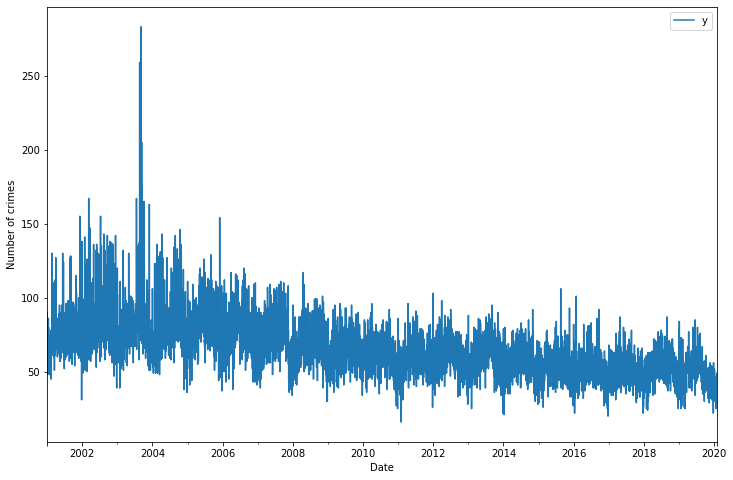

In [27]:
ax = pd_df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Number of crimes')
ax.set_xlabel('Date')
plt.show()

In [28]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3
# set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet(interval_width=0.95)

In [29]:
model.fit(pd_df[:5000])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/dat500/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



We must provide Prophet with a new DataFrame containing a ds column that holds the dates for which we want predictions. Use the built in make_future_dataframe for this

In [30]:
future_dates = model.make_future_dataframe(
    periods=30,
    freq='d',
    include_history=True
)

future_dates.tail()

ds
5025 2014-10-05
5026 2014-10-06
5027 2014-10-07
5028 2014-10-08
5029 2014-10-09

In [31]:
forecast = model.predict(future_dates)

The forecast dataframe returns a lot of columns. We can look at a subset of these:
* ds: the datestamp of the forecasted value
* yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
* yhat_lower: the lower bound of our forecasts
* yhat_upper: the upper bound of our forecasts

A variation in values from the output presented above is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, so values will be slightly different each time

In [32]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
5025 2014-10-05  52.383298   24.639144   76.487736
5026 2014-10-06  57.085003   29.307781   84.441049
5027 2014-10-07  63.585791   36.762502   89.199493
5028 2014-10-08  63.737772   36.537172   90.920000
5029 2014-10-09  63.353629   36.740054   88.360571

A quick and simple plot of the forecast.
Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values:

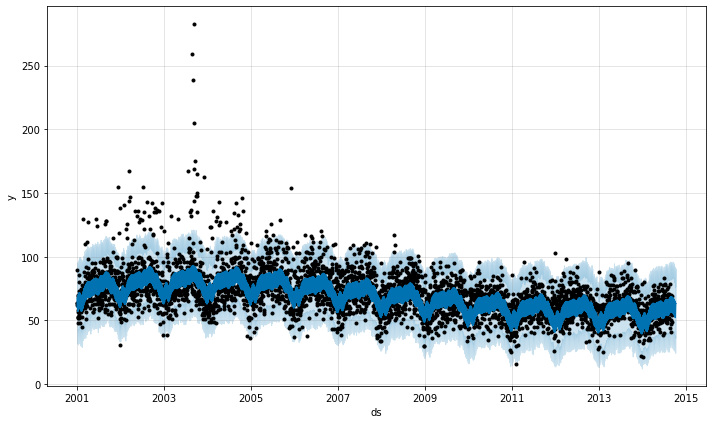

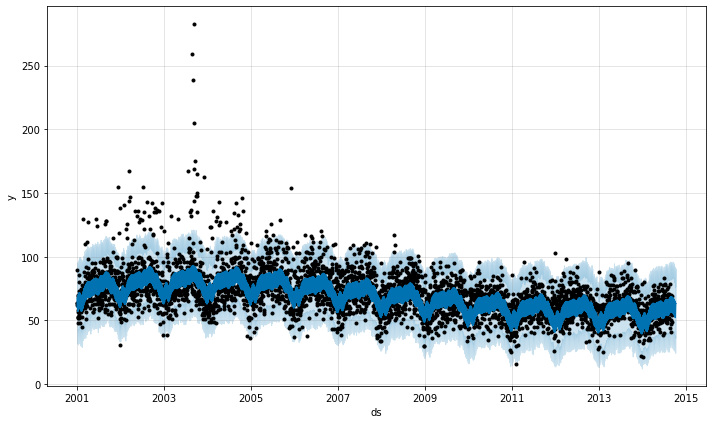

In [33]:
model.plot(forecast,
              uncertainty=True)

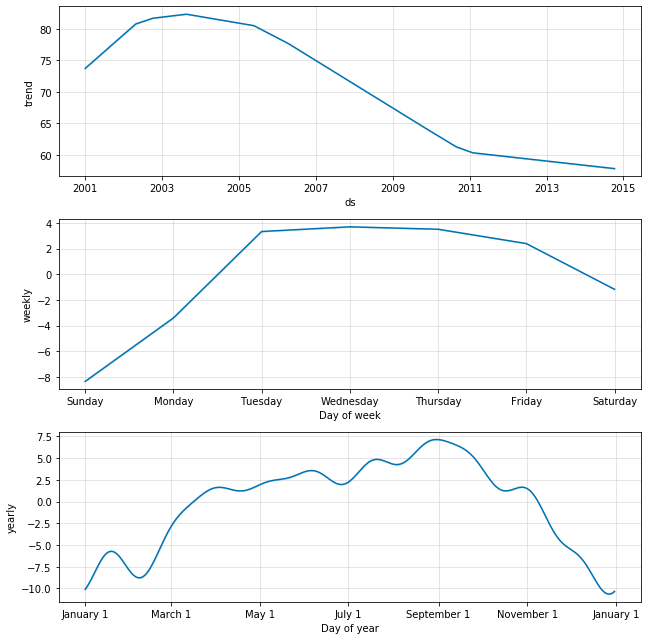

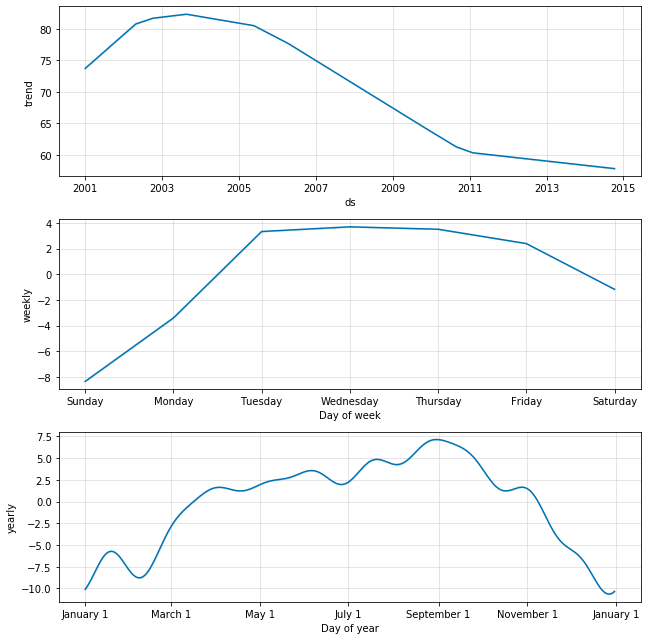

In [34]:
model.plot_components(forecast)

In [35]:
forecast.yhat.tail()

5025    52.383298
5026    57.085003
5027    63.585791
5028    63.737772
5029    63.353629
Name: yhat, dtype: float64

In [36]:
pd_df[5025:5029].y

5025    58
5026    55
5027    48
5028    58
Name: y, dtype: int64

Create interactive plot with plotly

In [37]:
py.init_notebook_mode()

fig = plot_plotly(model, forecast)  # This returns a plotly Figure
py.iplot(fig)

Compare predictions to true labels in a pandas dataframe

In [43]:
forecasted_data = {'predicted': forecast.yhat[5000:].apply(lambda x: int(x)), 'true': pd_df.y[5000:(len(forecast))]}
df_pred = pd.DataFrame(data=forecasted_data)
df_pred.head()

predicted  true
5000         68    38
5001         68    49
5002         66    50
5003         63    63
5004         55    45

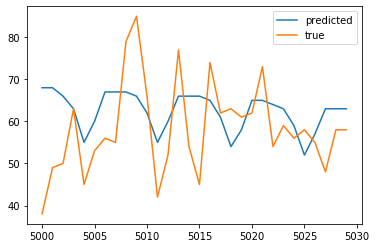

In [44]:
df_pred.plot()